In [2]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn 
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [3]:
# setting up the data directory
DATA_DIR="Data/cats_dogs/"

# setting up path for train and test data
train_dir=DATA_DIR+"/train"
test_dir=DATA_DIR+"/test"

In [4]:
# get the train files
file_train = tf.io.gfile.glob(train_dir + '/*/*')
# shuffle 
file_train = tf.random.shuffle(file_train)

train_ds=file_train

# get the test files
file_test = tf.io.gfile.glob(test_dir + '/*/*')
# shuffle 
file_test = tf.random.shuffle(file_test)


test_ds=file_test
print("Shape of train data:- ", train_ds.shape)
print("Shape of test data:- ",file_test.shape)

Shape of train data:-  (210,)
Shape of test data:-  (67,)


In [5]:
# Function to get waveform and it's label
def get_waveform_label(file):
  # get the label
  lab = tf.strings.split(file, os.path.sep)[-2]
  # read the binalry file 
  audio_binary = tf.io.read_file(file)
  # decode the file 
  audio, _ = tf.audio.decode_wav(audio_binary)
  # sqeeze tha audio
  waveform=tf.squeeze(audio, axis=-1)
  return waveform, lab

# get waveforms and labels of all files
AUTO = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_ds)
waveform_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTO)

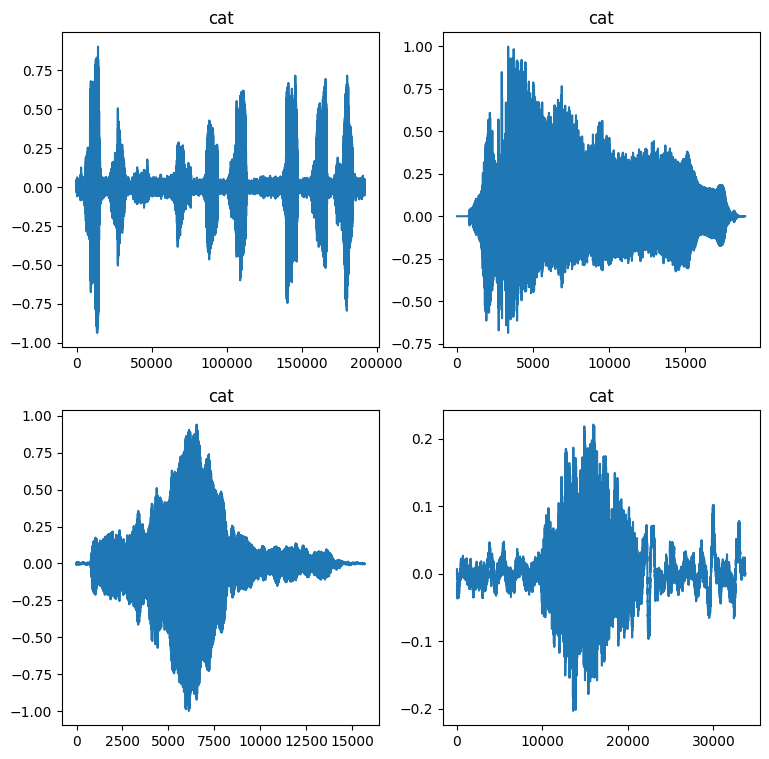

In [6]:
# number of rows and columns of plot
row,col = 2,2
n = row*col
fig, axs = plt.subplots(row, col, figsize=(9, 9))

# plotting waveforms
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // col
  c = i % col
  ax = axs[r][c]
  ax.plot(audio.numpy())

  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()


In [7]:
# function to get the spectogram and the labels
def get_spectrogram_label(audio, label):
  # apply padding
  padding = tf.zeros([300000] - tf.shape(audio), dtype=tf.float32)
  # get the spectogram of the audio
  wave = tf.cast(audio, tf.float32)
  eq_length = tf.concat([wave, padding], 0)
  spectrogram = tf.signal.stft(
      eq_length, frame_length=210, frame_step=110)    
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, -1)
  # get associated label of the audio
  label_id = tf.argmax(label == labels)
  # return the spectogram and the label
  return spectrogram, label_id

# get all the labels from the dataset   
labels = np.array(["cat","dog"])

# get the labels and spectogram
spectrogram_ds = waveform_ds.map(
    get_spectrogram_label, num_parallel_calls=AUTO)

C:\Users\Richard Patrick\AppData\Local\Temp\ipykernel_3140\1159814392.py:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


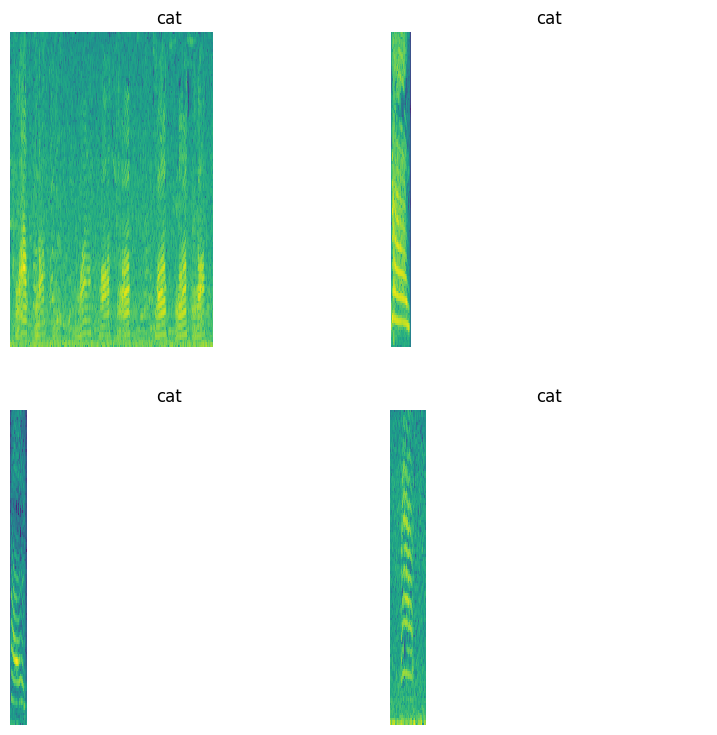

In [8]:
# function to plot the spectogram
def plot_spect(spectrogram, ax):
  # Converting frequencies to log and transpose to repesent time on x axis
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

# plot using a subplot
rows = 2
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  # function call
  plot_spect(np.squeeze(spectrogram.numpy()), ax)
  # set the title label
  ax.set_title(labels[label_id.numpy()])
  ax.axis('off')
plt.show()

In [9]:
# function to preprocess the data
def preprocess(file):
  files_ds = tf.data.Dataset.from_tensor_slices(file)
  # get waveforms and labels
  output_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTO)
  # get spectogram and labels
  output_ds = output_ds.map(
      get_spectrogram_label,  num_parallel_calls=AUTO)
 # return the data
  return output_ds

# train test and validate data
train_ds = spectrogram_ds

test_ds = preprocess(test_ds)

In [10]:
# initialize a batch size
batch_size = 64
# batch train and validate data
train_ds = train_ds.batch(batch_size)
# cache and prefetch the data
train_ds = train_ds.cache().prefetch(AUTO)

In [11]:
# building the model
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(labels)
# normalize adapt 
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

Input shape: (2726, 129, 1)


In [12]:
# adding layers
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                      